In [9]:
import pandas as pd

# Load the dataset
url = "C:/Users/Dun Yan/Desktop/covid-stft/daily-new-confirmed-covid-19-cases-per-million-people.csv"
data = pd.read_csv(url)

country = data[data['Entity']=='Japan']
signal = country['Daily new confirmed cases of COVID-19 per million people (rolling 7-day average, right-aligned)'].fillna(0).values


In [10]:
country

,Entity,Day,"Daily new confirmed cases of COVID-19 per million people (rolling 7-day average, right-aligned)"
226172,Japan,2020-01-09,0.0
226173,Japan,2020-01-10,0.0
226174,Japan,2020-01-11,0.0
226175,Japan,2020-01-12,0.0
226176,Japan,2020-01-13,0.0
...,...,...,...
228257,Japan,2025-09-24,0.0
228258,Japan,2025-09-25,0.0
228259,Japan,2025-09-26,0.0
228260,Japan,2025-09-27,0.0


Dataset loaded. Entities available: ['Afghanistan' 'Africa' 'Albania' 'Algeria' 'American Samoa' 'Andorra'
 'Angola' 'Anguilla' 'Antigua and Barbuda' 'Argentina'] ...

Analyzing entity: Japan (2090 days: 2020-01-09 -> 2025-09-28)


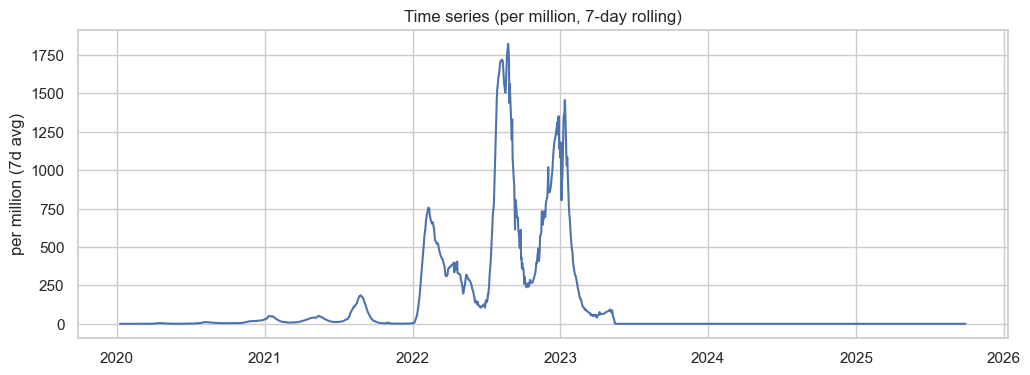

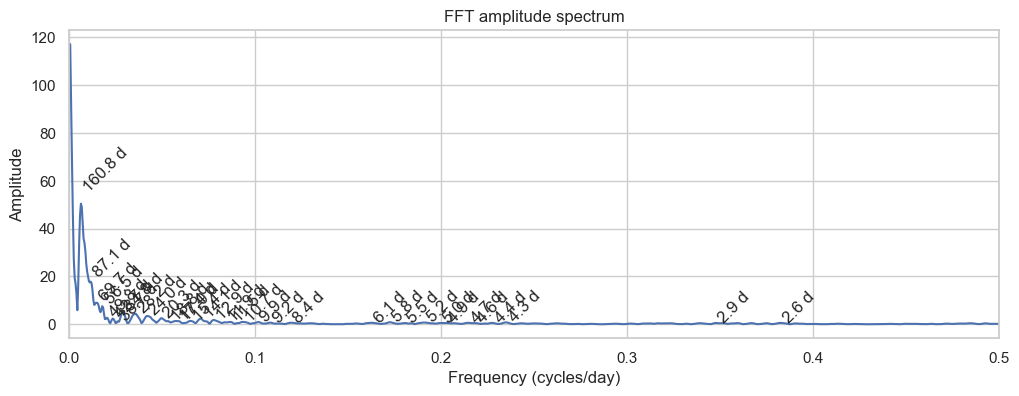

FFT peak frequencies (cycles/day) and approx periods (days):
  freq=0.0062 cyc/day  -> period ≈ 160.8 days, amp=50.433
  freq=0.0115 cyc/day  -> period ≈ 87.1 days, amp=17.855
  freq=0.0144 cyc/day  -> period ≈ 69.7 days, amp=8.997
  freq=0.0177 cyc/day  -> period ≈ 56.5 days, amp=7.538
  freq=0.0201 cyc/day  -> period ≈ 49.8 days, amp=2.678
  freq=0.0234 cyc/day  -> period ≈ 42.7 days, amp=2.396
  freq=0.0258 cyc/day  -> period ≈ 38.7 days, amp=1.176
  freq=0.0287 cyc/day  -> period ≈ 34.8 days, amp=4.991
  freq=0.0354 cyc/day  -> period ≈ 28.2 days, amp=4.431
  freq=0.0416 cyc/day  -> period ≈ 24.0 days, amp=3.426
  freq=0.0493 cyc/day  -> period ≈ 20.3 days, amp=2.519
  freq=0.0531 cyc/day  -> period ≈ 18.8 days, amp=1.334
  freq=0.0574 cyc/day  -> period ≈ 17.4 days, amp=1.389
  freq=0.0589 cyc/day  -> period ≈ 17.0 days, amp=1.302
  freq=0.0651 cyc/day  -> period ≈ 15.4 days, amp=1.374
  freq=0.0708 cyc/day  -> period ≈ 14.1 days, amp=2.324
  freq=0.0775 cyc/day  -> period ≈ 12.9 

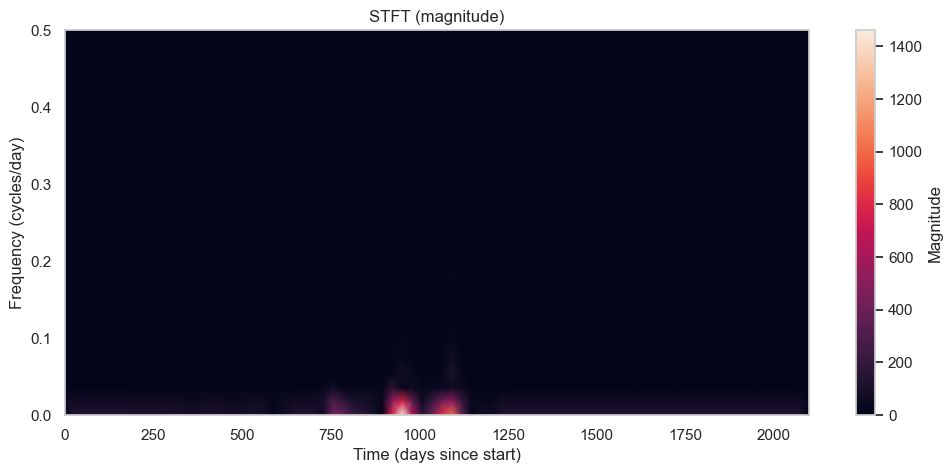


Detected 11 strong spikes (z>=3). Example spike dates: [Timestamp('2022-04-21 00:00:00'), Timestamp('2022-08-25 00:00:00'), Timestamp('2022-08-29 00:00:00'), Timestamp('2022-09-04 00:00:00'), Timestamp('2022-09-25 00:00:00'), Timestamp('2022-11-16 00:00:00'), Timestamp('2022-12-02 00:00:00'), Timestamp('2022-12-28 00:00:00'), Timestamp('2023-01-02 00:00:00'), Timestamp('2023-01-12 00:00:00')]

Deaths column not found in dataset; skipping case->death delay estimation. If you have deaths data, include a column named:
  'Daily new confirmed deaths of COVID-19 per million people (rolling 7-day average, right-aligned)'


In [15]:
# covid_analysis_using_provided_column.py
# Requires: pandas, numpy, scipy, matplotlib, seaborn
# pip install pandas numpy scipy matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import fftpack
from scipy.signal import stft, find_peaks, medfilt
from typing import Tuple, List

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

# ---------------------------
# Configure column names
# ---------------------------
CASES_COL_RAW = "Daily new confirmed cases of COVID-19 per million people (rolling 7-day average, right-aligned)"
# optional deaths column name (if your dataset has it)
DEATHS_COL_RAW = "Daily new confirmed deaths of COVID-19 per million people (rolling 7-day average, right-aligned)"

# Friendly short names used in analysis
CASES_COL = "new_cases_per_million_7d"
DEATHS_COL = "new_deaths_per_million_7d"

# ---------------------------
# Load dataset (assumes CSV)
# ---------------------------
def load_dataset(path_or_buffer: str) -> pd.DataFrame:
    """
    Load CSV with columns: Entity, Day, <cases column described>.
    Expects Day parseable as date.
    """
    df = pd.read_csv(path_or_buffer)
    # Normalize column names (strip)
    df.columns = [c.strip() for c in df.columns]
    # parse Day -> datetime
    if 'Day' in df.columns:
        df['Day'] = pd.to_datetime(df['Day'])
    elif 'Date' in df.columns:
        df['Day'] = pd.to_datetime(df['Date'])
    else:
        raise ValueError("No 'Day' or 'Date' column found. Please provide a date column named 'Day' or 'Date'.")
    # rename columns if present
    if CASES_COL_RAW in df.columns:
        df = df.rename(columns={CASES_COL_RAW: CASES_COL})
    else:
        raise ValueError(f"Cases column not found. Expected column name: '{CASES_COL_RAW}'")
    if DEATHS_COL_RAW in df.columns:
        df = df.rename(columns={DEATHS_COL_RAW: DEATHS_COL})
    # ensure 'Entity' exists
    if 'Entity' not in df.columns:
        raise ValueError("No 'Entity' column found (expected one describing country/region).")
    return df

# ---------------------------
# Helper: extract per-entity series
# ---------------------------
def series_for_entity(df: pd.DataFrame, entity: str, value_col: str = CASES_COL, fillna: bool = True) -> pd.Series:
    sub = df[df['Entity'] == entity].sort_values('Day').set_index('Day')
    if fillna:
        # these are already 7-day rolling per description, but fill small missing values
        sub[value_col] = sub[value_col].fillna(0)
    s = sub[value_col].astype(float)
    return s

# ---------------------------
# Periodicity via FFT + STFT
# ---------------------------
def detect_periodic_components_fft(series: pd.Series, fs: float = 1.0, show_plot: bool = True) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Return freqs, amps, peak_freqs, peak_amps.
    fs: sampling frequency in samples/day (1.0 for daily).
    """
    x = series.fillna(0).values
    n = len(x)
    x_d = x - np.nanmean(x)
    yf = fftpack.fft(x_d)
    xf = fftpack.fftfreq(n, d=1.0/fs)
    pos = xf > 0
    freqs = xf[pos]
    amps = np.abs(yf[pos]) / n
    # pick peaks in amplitude spectrum (tunable)
    peak_idx, _ = find_peaks(amps, height=np.percentile(amps, 75))
    peak_freqs = freqs[peak_idx]
    peak_amps = amps[peak_idx]
    if show_plot:
        plt.figure(figsize=(12,4))
        plt.plot(series.index, series.values)
        plt.title("Time series (per million, 7-day rolling)")
        plt.ylabel("per million (7d avg)")
        plt.show()
        plt.figure(figsize=(12,4))
        plt.plot(freqs, amps)
        plt.title("FFT amplitude spectrum")
        plt.xlim(0, 0.5)  # show low-frequency range (period >= 2 days)
        plt.xlabel("Frequency (cycles/day)")
        plt.ylabel("Amplitude")
        for f,a in zip(peak_freqs, peak_amps):
            period_days = 1.0/f if f>0 else np.inf
            plt.annotate(f"{period_days:.1f} d", xy=(f,a), xytext=(f, a*1.1), rotation=45)
        plt.show()
    return freqs, amps, peak_freqs, peak_amps

def visualize_stft(series: pd.Series, fs: float = 1.0, nperseg: int = 56, noverlap: int = 28, show_plot: bool = True):
    x = series.fillna(0).values
    f, t, Zxx = stft(x - np.nanmean(x), fs=fs, window='hann', nperseg=nperseg, noverlap=noverlap, boundary='zeros')
    if show_plot:
        plt.figure(figsize=(12,5))
        plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
        plt.ylim(0, 0.5)
        plt.xlabel("Time (days since start)")
        plt.ylabel("Frequency (cycles/day)")
        plt.title("STFT (magnitude)")
        plt.colorbar(label='Magnitude')
        plt.show()
    return f, t, Zxx

# ---------------------------
# Transient spike detection
# ---------------------------
def detect_spikes(series: pd.Series, med_window: int = 7, z_thresh: float = 3.0, min_prominence: float = 0.5) -> dict:
    """
    Returns dict with:
     - spike_indices (list of integer positions)
     - spike_dates (list of pd.Timestamp)
     - residual, baseline, zscore arrays
    min_prominence is in same units as series (per-million). Adjust to dataset scale.
    """
    arr = series.fillna(0).values
    # ensure odd kernel for medfilt
    k = med_window if med_window % 2 == 1 else med_window + 1
    baseline = medfilt(arr, kernel_size=k)
    residual = arr - baseline
    mad = np.median(np.abs(residual - np.median(residual)))
    if mad == 0:
        mad = np.std(residual) if np.std(residual) > 0 else 1.0
    zscore = residual / (1.4826 * mad)
    peaks_all, props = find_peaks(residual, prominence=min_prominence)
    # filter by z-score threshold
    peaks_filtered = [p for p in peaks_all if abs(zscore[p]) >= z_thresh]
    return {
        'peaks_indices': peaks_filtered,
        'peaks_dates': [series.index[p] for p in peaks_filtered],
        'residual': residual,
        'baseline': baseline,
        'zscore': zscore,
        'all_peaks_indices': peaks_all,
        'all_props': props
    }

# ---------------------------
# Correlation across entities (Pearson)
# ---------------------------
def correlation_matrix(df: pd.DataFrame, entities: List[str], value_col: str = CASES_COL) -> pd.DataFrame:
    # Build aligned DataFrame (index = union of dates)
    frames = []
    for e in entities:
        s = series_for_entity(df, e, value_col=value_col)
        s = s.rename(e)
        frames.append(s)
    big = pd.concat(frames, axis=1).fillna(0)
    corr = big.corr(method='pearson')
    return corr

# ---------------------------
# Cross-correlation delay estimation (only if deaths column exists)
# ---------------------------
def estimate_delay_between(series_a: pd.Series, series_b: pd.Series, max_lag_days: int = 60, show_plot: bool = True) -> Tuple[int, np.ndarray, np.ndarray]:
    """
    Returns best_lag (int) where positive means series_a leads series_b.
    Both series must be same index/length; function will intersect indices.
    """
    idx = series_a.index.intersection(series_b.index)
    a = series_a.loc[idx].fillna(0).values - np.nanmean(series_a.loc[idx].fillna(0).values)
    b = series_b.loc[idx].fillna(0).values - np.nanmean(series_b.loc[idx].fillna(0).values)
    corr_full = np.correlate(a, b, mode='full')
    lags = np.arange(-len(a)+1, len(a))
    mask = (lags >= -max_lag_days) & (lags <= max_lag_days)
    lags_sub = lags[mask]
    corr_sub = corr_full[mask]
    best_idx = np.argmax(corr_sub)
    best_lag = int(lags_sub[best_idx])
    if show_plot:
        plt.figure(figsize=(10,4))
        plt.plot(lags_sub, corr_sub)
        plt.axvline(best_lag, color='red', linestyle='--', label=f'best lag = {best_lag} days')
        plt.xlabel('Lag (days) -- positive means series A leads B')
        plt.title('Cross-correlation')
        plt.legend()
        plt.show()
    return best_lag, lags_sub, corr_sub

# ---------------------------
# Example pipeline
# ---------------------------
def run_pipeline(path_or_buffer: str, entity_a: str, entity_b: str = None):
    df = load_dataset(path_or_buffer)
    print(f"Dataset loaded. Entities available: {df['Entity'].unique()[:10]} ...")

    s_a = series_for_entity(df, entity_a, value_col=CASES_COL)
    print(f"\nAnalyzing entity: {entity_a} ({len(s_a)} days: {s_a.index.min().date()} -> {s_a.index.max().date()})")

    # 1) Periodicity
    freqs, amps, peak_freqs, peak_amps = detect_periodic_components_fft(s_a, show_plot=True)
    print("FFT peak frequencies (cycles/day) and approx periods (days):")
    for f,a in zip(peak_freqs, peak_amps):
        print(f"  freq={f:.4f} cyc/day  -> period ≈ {1.0/f:.1f} days, amp={a:.3f}")

    # 2) STFT
    _ = visualize_stft(s_a, nperseg=56, noverlap=28, show_plot=True)

    # 3) Spike detection
    spikes = detect_spikes(s_a, med_window=7, z_thresh=3.0, min_prominence=0.5)
    print(f"\nDetected {len(spikes['peaks_indices'])} strong spikes (z>=3). Example spike dates: {spikes['peaks_dates'][:10]}")

    # 4) Correlation across entities if entity_b provided
    if entity_b:
        corr = correlation_matrix(df, [entity_a, entity_b], value_col=CASES_COL)
        print(f"\nPearson correlation between {entity_a} and {entity_b}:")
        print(corr)
        # optional heatmap
        plt.figure(figsize=(6,4))
        sns.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap='vlag')
        plt.title("Correlation matrix")
        plt.show()

    # 5) Delay between cases and deaths if deaths column exists
    if DEATHS_COL in df.columns:
        if entity_b is None:
            # use same entity for deaths
            s_deaths = series_for_entity(df, entity_a, value_col=DEATHS_COL)
            best_lag, lags_sub, corr_sub = estimate_delay_between(s_a, s_deaths, max_lag_days=60, show_plot=True)
            print(f"Estimated lag (cases lead deaths) for {entity_a}: {best_lag} days")
        else:
            # user asked for two entities; we still compute cases->deaths for entity_a if available
            s_deaths = series_for_entity(df, entity_a, value_col=DEATHS_COL)
            best_lag, lags_sub, corr_sub = estimate_delay_between(s_a, s_deaths, max_lag_days=60, show_plot=True)
            print(f"Estimated lag (cases lead deaths) for {entity_a}: {best_lag} days")
    else:
        print("\nDeaths column not found in dataset; skipping case->death delay estimation. If you have deaths data, include a column named:")
        print(f"  '{DEATHS_COL_RAW}'")

    return {
        'series': s_a,
        'fft': (freqs, amps, peak_freqs, peak_amps),
        'stft': None,  # returned in visualize if needed
        'spikes': spikes,
        'corr_matrix': corr if entity_b else None
    }

# ---------------------------
# Example usage (uncomment to run)
# ---------------------------
# results = run_pipeline("C:/Users/Dun Yan/Desktop/covid-stft/daily-new-confirmed-covid-19-cases-per-million-people.csv", entity_a="United States", entity_b="United Kingdom")
# If you only have cases and want per-entity run:
results = run_pipeline("C:/Users/Dun Yan/Desktop/covid-stft/daily-new-confirmed-covid-19-cases-per-million-people.csv", entity_a="Japan")


In [6]:
E_x = sum(x**2) / fs  # Energy of x
# Calculate a two-sided STFT with PSD scaling:
f, t, Zxx = signal.stft(x, fs, nperseg=1000, return_onesided=False,
                        scaling='psd')
# Integrate numerically over abs(Zxx)**2:
df, dt = f[1] - f[0], t[1] - t[0]
E_Zxx = sum(np.sum(Zxx.real**2 + Zxx.imag**2, axis=0) * df) * dt
# The energy is the same, but the numerical errors are quite large:
np.isclose(E_x, E_Zxx, rtol=1e-2)

np.True_